# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [79]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

In [80]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [81]:
mnist = fetch_openml('mnist_784', cache=False)

In [82]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [83]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [84]:
X /= 255.0

In [85]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [87]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [88]:
X_train.shape, y_train.shape

((63000, 784), (63000,))

### Print a selection of training images and their labels

In [89]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

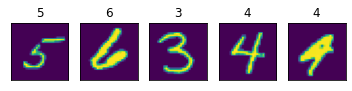

In [90]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [91]:
import torch
from torch import nn
import torch.nn.functional as F

In [92]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [93]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [94]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [95]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [96]:
from skorch import NeuralNetClassifier

In [97]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [98]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7754       0.9011        0.3586  0.9760
      2        0.4101       0.9195        0.2785  1.0132
      3        0.3419       0.9320        0.2369  0.9837
      4        0.3070       0.9408        0.2108  0.9851
      5        0.2804       0.9454        0.1921  0.9566
      6        0.2589       0.9500        0.1779  0.9564
      7        0.2467       0.9529        0.1668  0.9641
      8        0.2329       0.9546        0.1571  0.9627
      9        0.2184       0.9570        0.1491  0.9703
     10        0.2147       0.9582        0.1451  0.9786
     11        0.2072       0.9589        0.1390  0.9735
     12        0.2004       0.9607        0.1340  0.9602
     13        0.1915       0.9617        0.1310  0.9776
     14        0.1874       0.9614        0.1272  0.9738
     15        0.1843       0.9640        0.1241  0.9668
     16        0.1786       0.9

## Prediction

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
y_pred = net.predict(X_test)
y_pred.shape

(7000,)

In [101]:
df_val = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_val

,Actual,Predicted
0,6,6
1,2,2
2,7,7
3,5,5
4,7,7
...,...,...
6995,3,3
6996,1,1
6997,2,2
6998,5,5


In [102]:
accuracy_score(y_test, y_pred)

0.962

In [117]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[638,   0,   0,   2,   2,   5,   4,   0,   2,   2],
       [  0, 825,   4,   2,   0,   0,   0,   0,   1,   1],
       [  1,   5, 695,   7,   3,   0,   1,   6,   4,   0],
       [  1,   1,   7, 684,   1,   7,   2,   8,   1,   6],
       [  2,   2,   1,   0, 608,   0,   3,   4,   2,  15],
       [  1,   2,   1,  13,   2, 615,   7,   2,   4,   4],
       [  2,   0,   0,   0,   2,   4, 662,   0,   1,   0],
       [  4,   3,   3,   1,   8,   0,   0, 717,   2,   6],
       [  6,   8,   3,   6,   4,   3,   5,   2, 628,   5],
       [  0,   3,   0,  10,  13,   1,   1,   8,   1, 662]])

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [103]:
error_mask = y_pred != y_test

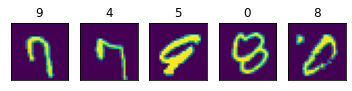

In [104]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [105]:
XCnn = X.reshape(-1, 1, 28, 28)

In [106]:
XCnn.shape

(70000, 1, 28, 28)

In [107]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.1, random_state=1)

In [108]:
XCnn_train.shape, y_train.shape

((63000, 1, 28, 28), (63000,))

In [109]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [110]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [111]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4285       0.9752        0.0791  2.0325
      2        0.1611       0.9830        0.0546  1.9116
      3        0.1287       0.9852        0.0473  1.8945
      4        0.1138       0.9864        0.0416  1.9085
      5        0.1011       0.9869        0.0417  1.9122
      6        0.0931       0.9881        0.0389  1.9031
      7        0.0869       0.9863        0.0439  1.9098
      8        0.0814       0.9906        0.0344  1.9093
      9        0.0785       0.9897        0.0347  1.8957
     10        0.0749       0.9896        0.0340  1.9051


In [112]:
y_pred_cnn = cnn.predict(XCnn_test)
y_pred_cnn.shape

(7000,)

In [113]:
df_cnn = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred_cnn})
df_cnn

,Actual,Predicted
0,6,6
1,2,2
2,7,7
3,5,5
4,7,7
...,...,...
6995,3,3
6996,1,1
6997,2,2
6998,5,5


In [114]:
accuracy_score(y_test, y_pred_cnn)

0.9884285714285714

In [118]:
confusion_matrix(y_test, y_pred_cnn)

array([[649,   0,   1,   0,   1,   0,   3,   0,   0,   1],
       [  0, 824,   3,   1,   0,   0,   1,   3,   1,   0],
       [  0,   1, 714,   2,   0,   0,   1,   4,   0,   0],
       [  0,   1,   3, 707,   0,   4,   0,   2,   0,   1],
       [  0,   0,   1,   0, 628,   0,   1,   1,   2,   4],
       [  0,   0,   0,   2,   0, 642,   4,   0,   2,   1],
       [  1,   0,   0,   0,   0,   1, 667,   0,   2,   0],
       [  0,   1,   2,   1,   0,   0,   0, 740,   0,   0],
       [  2,   2,   3,   0,   1,   1,   3,   1, 657,   0],
       [  0,   1,   2,   1,   2,   0,   1,   0,   1, 691]])

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [115]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.8045112781954887

Over 70% of the previously misclassified images are now correctly identified.

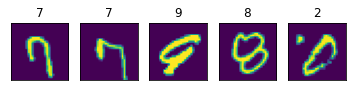

In [116]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])